# AE vs VAE for MNIST 

**All sources can be found in the notebook called ECG AE Anomaly detection.ipynb**

I don't have access to torchvision because my cuda is too recent. So I had to do the dataloading myself. You probably don't have to.


We are going to consider the MNIST dataset as tabular data of 784 features (28*28 pixels =784).Indeed we are going to use mulilayer perceptron and not convolutional layers here. First because we actually don't really need it, second because it is easier, third because this is the kind of data I am actually going to work with in the projects.

The auto encoder will look like 784->400->50->400->784 : so we are going to represent our images (vector of length 784) into a 50 dimensional latent space, using 2 perceptrons as an encoder and 2 perceptrons as a decoder.

In [6]:
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

train_samples = 60000
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)


# Pyro VAE

In [7]:
import os

import numpy as np
import torch

import torch.nn as nn


import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [8]:
import torch; torch.manual_seed(0)

import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [9]:
assert pyro.__version__.startswith('1.7.0')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
class Decoder_pyro(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img
    
    
class Encoder_pyro(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

        
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder_pyo(z_dim, hidden_dim)
        self.decoder = Decoder_pyro(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder(z)
            # score against actual images(I now understand why they ask to rescale the image but still don't get
            # why thsy use bernoulli : it can't be bernouilli. The only answer I found on internet was : it work
            # best that way....)
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [11]:
from torch.utils.data import Dataset
class Mnist_dataset(Dataset):
    def __init__(self,images,targets):
        self.images=images
        self.targets=targets
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        image=self.images[item]
        re_image=image/255
        target=int(self.targets[item])
        return {'re_image': torch.tensor(re_image.reshape(28,28)[np.newaxis,:,:], dtype=torch.float32),
                'target': torch.tensor(target, dtype=torch.long)
               }

In [12]:


def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for d in train_loader:
        # if on GPU put mini-batch into CUDA memory
        x=d['re_image']
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [13]:
LEARNING_RATE = 1.0e-3
USE_CUDA = True


NUM_EPOCHS = 20


In [14]:
i_dataset = Mnist_dataset(images=X_train,targets=y_train)

i_data_loader = torch.utils.data.DataLoader(i_dataset,batch_size=128,num_workers=16)

In [15]:
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, i_data_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    #print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    

In [16]:
def loss_plot_pyro(loss):
    fig=plt.figure(figsize=(5,5))
    plt.plot(np.arange(len(loss)),loss)
    plt.xlabel('Epochs')
    plt.ylabel('ELBO')
    plt.show()

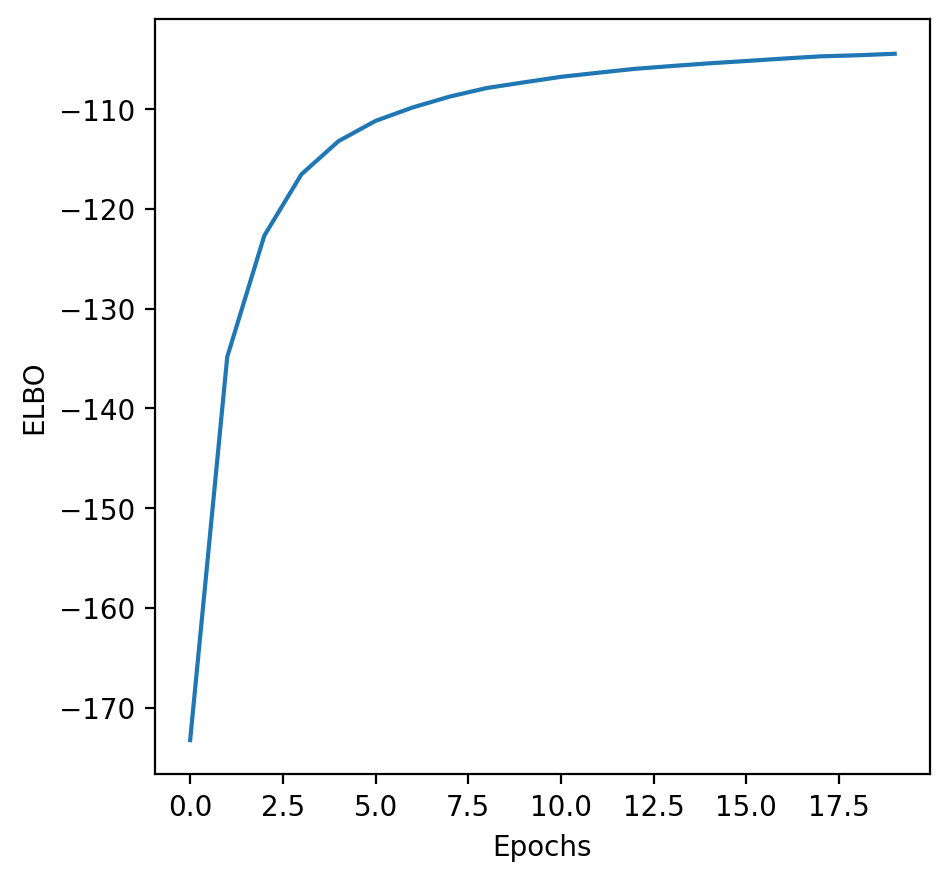

In [17]:
loss_plot_pyro(train_elbo)

In [18]:
import umap.umap_ as umap

def plot_latent_var_pyro(autoencoder, data,nei, num_batches=100):
    stack=[]
    stacky=[]
    for i, d in enumerate(data):
        x=d['re_image']
        y=d['target'].to('cpu').detach().numpy().tolist()
        z,sigma = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy().tolist()
        stack.extend(z)
        stacky.extend(y)
        #umaper = umap.UMAP(n_components=2,n_neighbors=nei)
        #x_umap = umaper.fit_transform(z)
        #plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            umaper = umap.UMAP(n_components=2,n_neighbors=nei)
            x_umap = umaper.fit_transform(stack)
            plt.scatter(x_umap[:, 0], x_umap[:, 1],s=2, c=stacky, cmap='tab10')
            plt.colorbar()
            plt.xlabel('UMAP 1')
            plt.ylabel('UMAP 2')
            break

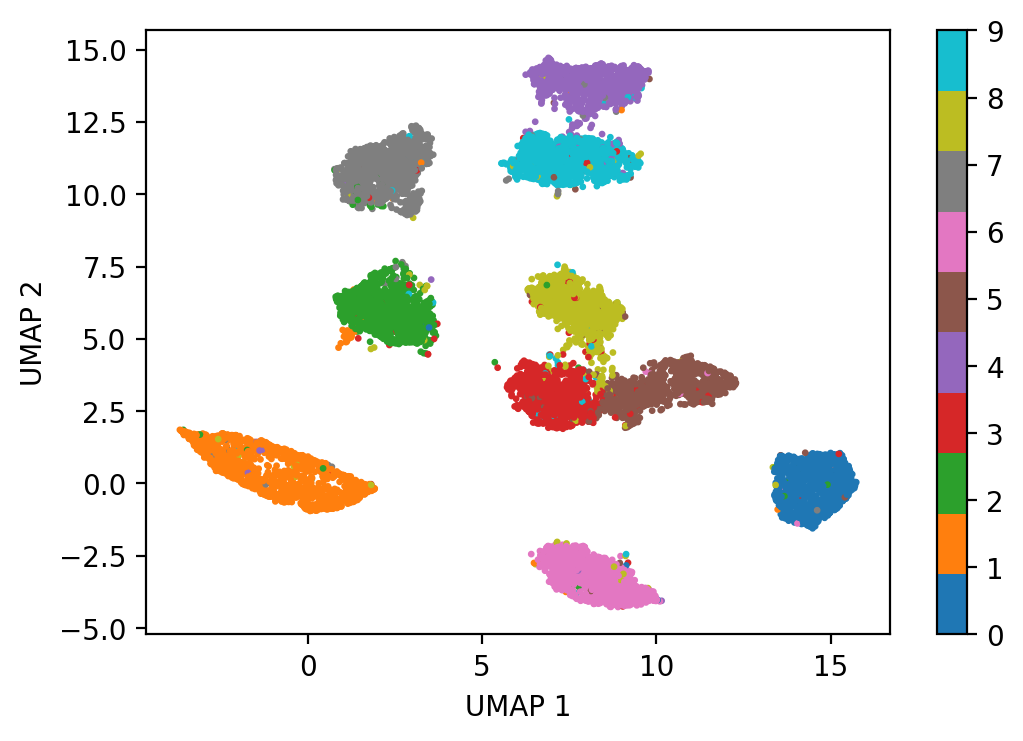

In [19]:
plot_latent_var_pyro(vae, i_data_loader,10)

# Pytorch AE multilayer perceptron

In [20]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 400)
        self.linear2 = nn.Linear(400, latent_dims)
        
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [21]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 400)
        self.linear2 = nn.Linear(400, 784)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [22]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [23]:
keep_loss=[]
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        loss_epo=[]
        for d in data:
            x=d['re_image']
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).mean()
            loss.backward()
            opt.step()
            loss_epo.append(loss.cpu().detach().numpy())
        keep_loss.append(np.mean(loss_epo))
    return autoencoder

In [24]:
latent_dims = 50
autoencoder = Autoencoder(latent_dims).to(device) # GPU

i_dataset = Mnist_dataset(images=X_train,targets=y_train)

i_data_loader = torch.utils.data.DataLoader(i_dataset,batch_size=128,num_workers=16)

autoencoder = train(autoencoder, i_data_loader)

In [25]:
import umap.umap_ as umap

def plot_latent(autoencoder, data,nei, num_batches=100):
    stack=[]
    stacky=[]
    for i, d in enumerate(data):
        x=d['re_image']
        y=d['target'].to('cpu').detach().numpy().tolist()
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy().tolist()
        stack.extend(z)
        stacky.extend(y)
        #umaper = umap.UMAP(n_components=2,n_neighbors=nei)
        #x_umap = umaper.fit_transform(z)
        #plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            umaper = umap.UMAP(n_components=2,n_neighbors=nei)
            x_umap = umaper.fit_transform(stack)
            plt.scatter(x_umap[:, 0], x_umap[:, 1],s=2, c=stacky, cmap='tab10')
            plt.colorbar()
            plt.xlabel('UMAP 1')
            plt.ylabel('UMAP 2')
            break
            
def loss_plot(loss):
    fig=plt.figure(figsize=(5,5))
    plt.plot(np.arange(len(loss)),loss)
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.show()

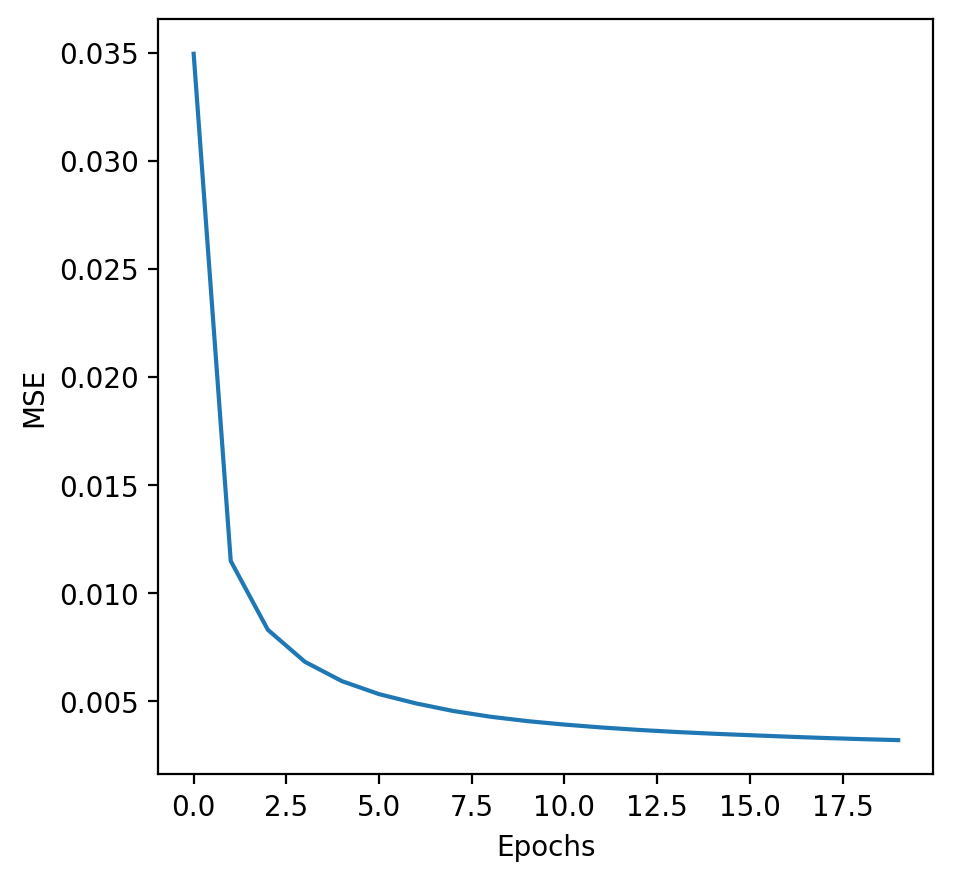

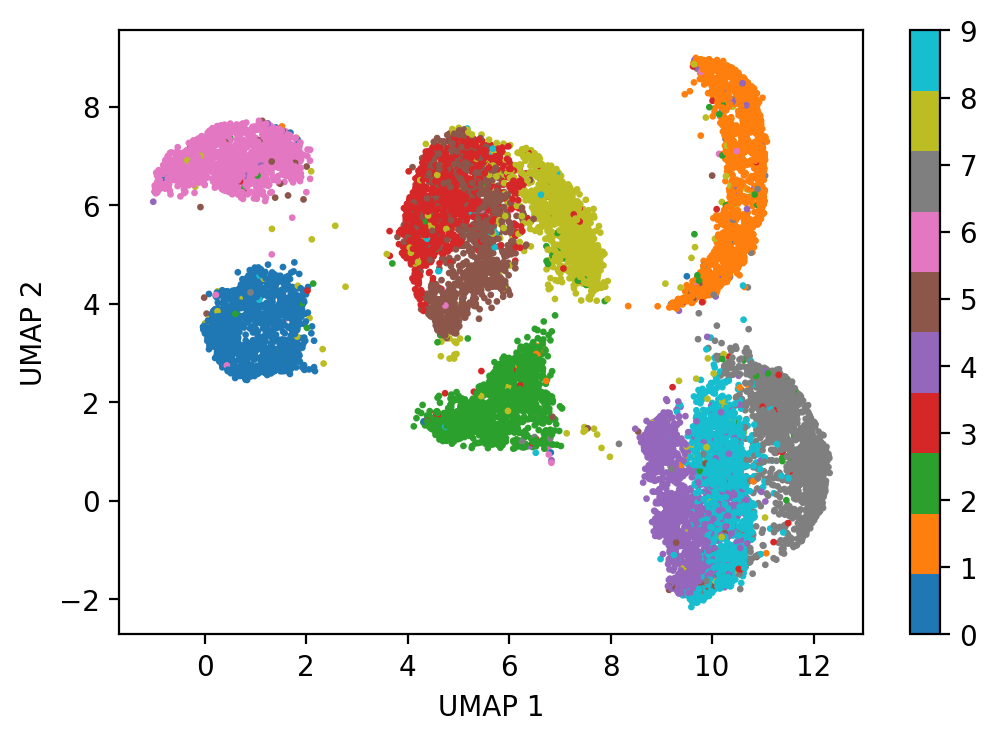

In [26]:
loss_plot(keep_loss)
plot_latent(autoencoder, i_data_loader,100)